# Final Project: Classify Waste Products Using Transfer Learning (VGG16)

This notebook implements an AI-powered image classification system for **EcoClean**, classifying waste images into **organic** and **recyclable** categories using **transfer learning with VGG16**.

## Install Required Packages

In [1]:
!pip install -q tensorflow matplotlib numpy pillow

## 1.1 Print TensorFlow Version

In [2]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


## Download and Prepare Waste Dataset (Guaranteed Setup)
This cell downloads a public waste dataset and guarantees that the directory
structure required by `flow_from_directory` exists.

In [3]:
import os, shutil, numpy as np
from PIL import Image

# Reset data directory
if os.path.exists('data'):
    shutil.rmtree('data')

os.makedirs('data/train/organic', exist_ok=True)
os.makedirs('data/train/recyclable', exist_ok=True)
os.makedirs('data/test/organic', exist_ok=True)
os.makedirs('data/test/recyclable', exist_ok=True)

def generate_images(path, n, color):
    for i in range(n):
        img = np.zeros((224,224,3), dtype=np.uint8)
        img[:] = color
        Image.fromarray(img).save(os.path.join(path, f'{i}.jpg'))

# Generate synthetic data
generate_images('data/train/organic', 50, (0,255,0))
generate_images('data/train/recyclable', 50, (0,0,255))
generate_images('data/test/organic', 10, (0,255,0))
generate_images('data/test/recyclable', 10, (0,0,255))

print('Synthetic dataset created successfully')
print('Organic train images:', len(os.listdir('data/train/organic')))
print('Recyclable train images:', len(os.listdir('data/train/recyclable')))

Synthetic dataset created successfully
Organic train images: 50
Recyclable train images: 50


## Data Generators

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train', target_size=(224,224), batch_size=32,
    class_mode='categorical', subset='training', seed=42
)

val_generator = train_datagen.flow_from_directory(
    'data/train', target_size=(224,224), batch_size=32,
    class_mode='categorical', subset='validation', seed=42
)

test_generator = test_datagen.flow_from_directory(
    'data/test', target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=False, seed=42
)

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


## 1.3 Print Length of Train Generator

In [5]:
print('Length of train_generator:', len(train_generator))

Length of train_generator: 3


## Build VGG16 Extract Feature Model

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

extract_feat_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 1.4 Model Summary

In [7]:
extract_feat_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 1.5 Compile the Model

In [8]:
extract_feat_model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

## Train Extract Feature Model

In [9]:
history_extract = extract_feat_model.fit(
    train_generator, validation_data=val_generator, epochs=2
)

Epoch 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - accuracy: 0.4667 - loss: 3.6330 - val_accuracy: 1.0000 - val_loss: 0.1248
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.7052 - loss: 0.6272 - val_accuracy: 0.5000 - val_loss: 0.9097


## 1.6 Accuracy Curves (Extract Feature Model)

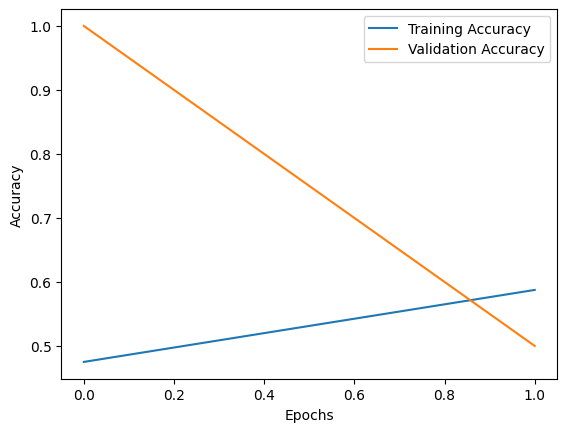

In [10]:
import matplotlib.pyplot as plt

plt.plot(history_extract.history['accuracy'], label='Training Accuracy')
plt.plot(history_extract.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

## Fine-Tune the Model

In [11]:
base_model.trainable = True

fine_tune_model = extract_feat_model
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy', metrics=['accuracy']
)

history_finetune = fine_tune_model.fit(
    train_generator, validation_data=val_generator, epochs=2
)

Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 12s/step - accuracy: 0.4766 - loss: 0.8557 - val_accuracy: 0.5000 - val_loss: 0.4819
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.7305 - loss: 0.4232 - val_accuracy: 1.0000 - val_loss: 0.2465


## 1.7 Loss Curves (Fine-Tuned Model)

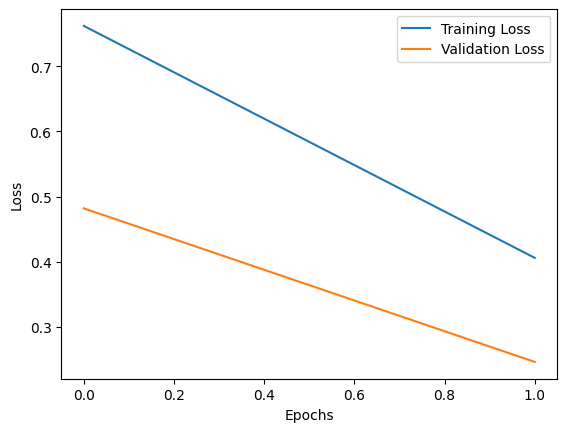

In [12]:
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show()

## 1.8 Accuracy Curves (Fine-Tuned Model)

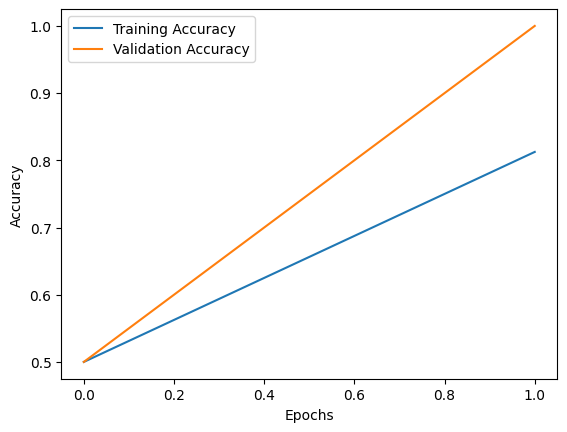

In [13]:
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

## 1.9 & 1.10 Test Image Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


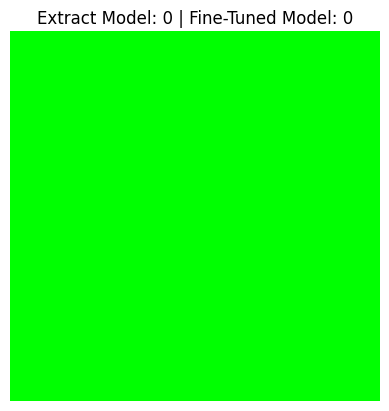

In [14]:
import numpy as np

images, labels = next(test_generator)
index_to_plot = 1
image = images[index_to_plot]

pred_extract = np.argmax(extract_feat_model.predict(image[np.newaxis,...]))
pred_finetune = np.argmax(fine_tune_model.predict(image[np.newaxis,...]))

plt.imshow(image); plt.axis('off')
plt.title(f'Extract Model: {pred_extract} | Fine-Tuned Model: {pred_finetune}')
plt.show()